In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import cv2
import dlib
import matplotlib.pyplot as plt
from PIL import Image

import os
data_path = '/kaggle/input/lfwpeople'
print("Data directory:", os.listdir(data_path))


Data directory: ['pairsDevTrain.txt', 'lfw-funneled.tgz', 'pairsDevTest.txt', 'pairs.txt']


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)  # Lists directories found under /kaggle/input, checking structure

/kaggle/input
/kaggle/input/lfwpeople
/kaggle/input/haarcascades


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/lfwpeople'):
    print(f"Directory: {dirname}")
    for filename in filenames:
        print(f"File: {filename}")


Directory: /kaggle/input/lfwpeople
File: pairsDevTrain.txt
File: lfw-funneled.tgz
File: pairsDevTest.txt
File: pairs.txt


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input/face-detection-haarcascades'):
    print(f"Directory: {dirname}")
    for filename in filenames:
        print(f"File: {filename}")

In [5]:
import tarfile

# Path to the tar file
tar_file_path = '/kaggle/input/lfwpeople/lfw-funneled.tgz'
extract_path = '/kaggle/working/lfw-funneled'  # Location to extract files

with tarfile.open(tar_file_path, 'r:gz') as tar_ref:
    tar_ref.extractall(extract_path)


In [6]:

# Path to the root folder containing all identity folders (e.g., '/path/to/lfw_funneled')
data_dir = "/kaggle/working/lfw-funneled/lfw_funneled"

# Define the transformations (e.g., resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to a fixed size (optional)
    transforms.ToTensor(),                 # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalization for pre-trained models
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create a DataLoader to batch the data
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels: tensor([5677, 1091, 4428, 4098,  903, 2288,  578, 3824,  227, 3386, 4748, 3341,
        3946, 2510, 1550, 3062, 2242, 5536,  724, 1047, 2206, 5458,  357, 2172,
         370, 1101, 1404, 3127, 1047, 5267,  933, 2828])


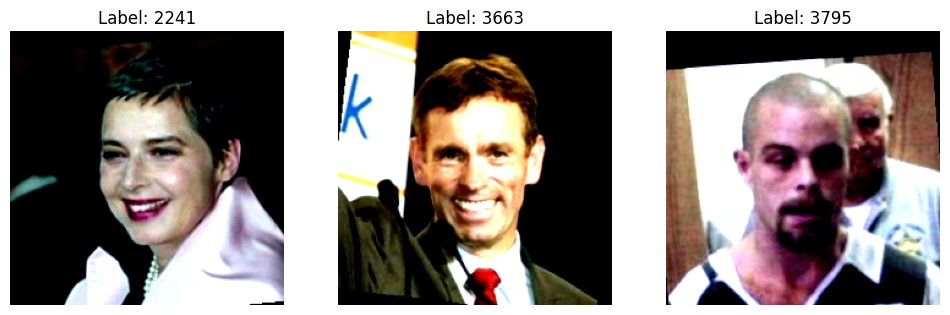

In [7]:
# Get one batch of data and viewing it
data_iter = iter(dataloader)
images, labels = next(data_iter)

print(f"Batch of images shape: {images.shape}")  # Example: (32, 3, 224, 224) for batch_size=32
print(f"Batch of labels: {labels}")


# Unnormalize function (since you normalized during loading)
def unnormalize(tensor):
    return tensor * 0.5 + 0.5  # Reverse normalization: (x - mean) / std -> x = x*std + mean

# Get one batch of images and labels
images, labels = next(data_iter)

# Select a few images to visualize (e.g., first 3 images in the batch)
num_images_to_show = 3
fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 4))

for i in range(num_images_to_show):
    ax = axes[i]
    img = unnormalize(images[i])  # Undo normalization
    img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {labels[i]}")

plt.show()



FACE DETECTION

In [8]:
faceCascadePath = "../input/haarcascades/haarcascade_frontalface_default.xml"

In [9]:
class FaceDetector():

    def __init__(self,faceCascadePath):
        self.faceCascade=cv2.CascadeClassifier(faceCascadePath)


    def detect(self, image, scaleFactor=1.1,
               minNeighbors=5,
               minSize=(30,30)):
        
        #function return rectangle coordinates of faces for given image
        rects=self.faceCascade.detectMultiScale(image,
                                                scaleFactor=scaleFactor,
                                                minNeighbors=minNeighbors,
                                                minSize=minSize)
        return rects

class FaceAlignedDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None, faceCascadePath=None):
        super().__init__(root, transform)
        self.face_detector = FaceDetector(faceCascadePath)
    
def __getitem__(self, index):
    # Fetch the image and label from the ImageFolder dataset
    img, label = super().__getitem__(index)
    
    # Convert the PIL image to a numpy array for OpenCV usage
    img_cv = np.array(img)
    
    # Ensure the image is in grayscale for the classifier
    if len(img_cv.shape) == 3:  # Check if the image has 3 channels
        gray_img = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = img_cv  # Image is already single-channel
    
    # Check if grayscale conversion was successful and valid
    if gray_img.dtype != 'uint8':
        gray_img = gray_img.astype('uint8')
    
    # Detect faces in the image
    faces = self.face_detector.detect(gray_img)
    
    if len(faces) > 0:
        # Process the first detected face
        x, y, w, h = faces[0]  # (x, y, w, h) bounding box
        face_img = img_cv[y:y+h, x:x+w]  # Crop detected face region
        
        # Convert back to PIL for further processing
        face_img_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
        
        if self.transform:
            face_img_pil = self.transform(face_img_pil)
        
        return face_img_pil, label
    else:
        # If no faces detected, return original image
        if self.transform:
            img = self.transform(img)
        return img, label





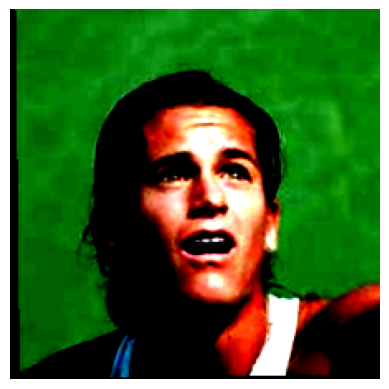

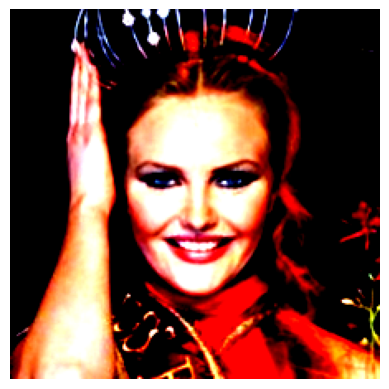

In [10]:
# Your transformations (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = FaceAlignedDataset(root=data_dir, transform=transform, faceCascadePath=faceCascadePath)

# DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Loop over the DataLoader (processing batch of images)
for batch_idx, (inputs, labels) in enumerate(dataloader):
    if batch_idx == 0:  # Show the first image in the batch for checking
        img = inputs[0].permute(1, 2, 0).numpy()
        img = np.clip(img * 255, 0, 255).astype(np.uint8)  # Convert tensor to image
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    elif batch_idx == 2:  # Show the 3rd image in the batch for checking
        img = inputs[0].permute(1, 2, 0).numpy()
        img = np.clip(img * 255, 0, 255).astype(np.uint8)  # Convert tensor to image
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    

In [11]:
print("File exists:", os.path.exists(faceCascadePath))

File exists: True
